In [1]:
import sys
sys.path.insert(1, '../../ana_tools')
import getters, tools, graphic_tools, setters
import matplotlib.pyplot as plt
plt.style.use('../../ana_tools/presentation.mplstyle')
import numpy as np
from scipy.optimize import curve_fit
path = "/eos/user/j/jcapotor/FBGana/camara_climatica/FebruaryRuns/"
plateaus = getters.get_plateaus()
rtdcalib = getters.get_rtdcal()

/eos/home-j/jcapotor/SWAN_projects/FBG_TMS
/eos/home-j/jcapotor/SWAN_projects/FBG_TMS/ana_tools/plateaus.json
/eos/home-j/jcapotor/SWAN_projects/FBG_TMS
/eos/home-j/jcapotor/SWAN_projects/FBG_TMS/ana_tools/rtd_calib.json


In [2]:
def line(x, A, B):
    return A + B*x

def exp(x, A, B, C):
    return C+A*np.exp(-x/B)

def log(x, A, B, C):
    return C+A*np.exp(-x/B)

# Description of the 2023 February Runs #

The objective of this notebook is to characterise the setups used for the runs taken during February 2023 at the IFIC facilities.

In this notebook **only information about the setup will be found.** Here we will explain in detail the characteristics of the setup, mainly focusing on the position of the RTD sensors.
## Climatic Chamber, IFIC ##

Two different setups can be differentiated during February. We have two covers for the copper cylinder, one that is made out of polystyrene and another one that is a copper lid.

* 20230221: Polystyrene lid.

* 20230222: Polystyrene lid.

* 20230223: Copper lid.

* 20230224: Copper lid.

# Obtention of the stabilisation times

One interesting thing to observe are the stablisation times for the temperature inside the cylinder at different temperatures.

To calculate them, one fits the temperature curve to an exponential and finds the time where temperature has stabilised.

The stabilisation is defined with respect to a tolerance. This tolerance is calculated as the RMS of the difference between the fitted curve and the real data. When the fitted line reaches a value which is one tolerance above the value at infinite, then that is the stabilisation time.

Keys to read: ['Temp1']


Reading temperature key: Temp: 100%|██████████| 1/1 [00:00<00:00,  3.88it/s]


273_down Stabilisation time: 5393 s for tolerance 98 mK
253_down Stabilisation time: 5085 s for tolerance 106 mK
233_down Stabilisation time: 4563 s for tolerance 107 mK
213_down Stabilisation time: 4703 s for tolerance 85 mK
233_up Stabilisation time: 4205 s for tolerance 119 mK
253_up Stabilisation time: 4735 s for tolerance 115 mK
273_up Stabilisation time: 4707 s for tolerance 122 mK


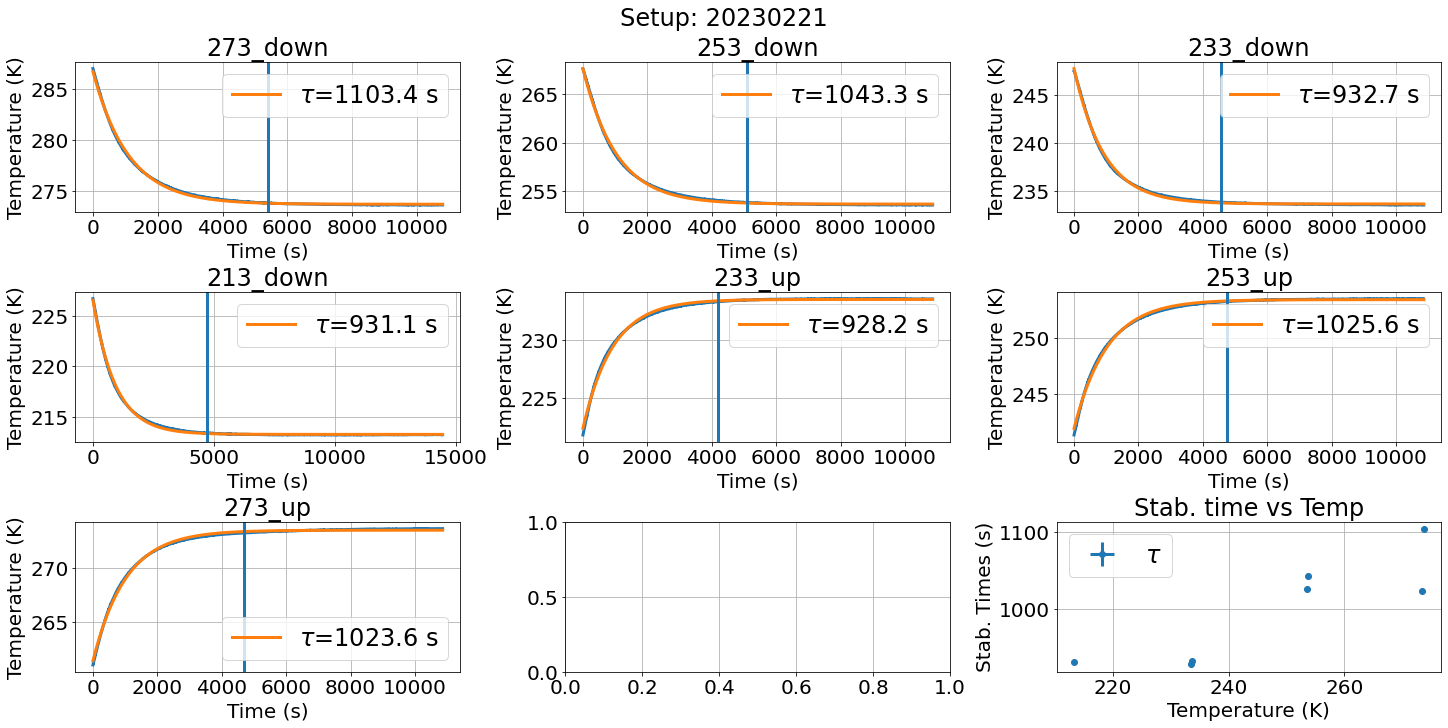

In [3]:
date = "20230221"
ids = {"T1":"37129", "T2":"39643"}
colors = {"T1":"blue", "T2":"orange", "T3":"red", "T4":"green", "T5":"purple", "T6":"black"}
def plot_stabilization_time(date, ids, ncols, nrows, show=True, filetype="temperature"):
    if filetype == "temperature":
        pol="Temp"
        sens="T1"
    if filetype == "peaks":
        pol = "Av"
        sens="Wav1-1"
    rtds = getters.get_raw_data(path_to_split=path+date+"/",
                                filetype=filetype,
                                pol=pol).sort_values(by="Timestamp").reset_index(drop=True)
    n_plateaus = len(plateaus[date].keys())
    fig, axes = graphic_tools.make_figure(ncols=ncols, nrows=nrows)
    fig.set_size_inches(20, 10)
    fig.suptitle("Setup: " + date)
    cnt = 0
    taus, taus_err = [], []
    temps, temps_err = [], []
    tolerances, tinfs = [], []
    for plateau in plateaus[date].keys():
        t0 = plateaus[date][plateau][0]
        tf = plateaus[date][plateau][1]
        tcut = rtds.loc[(rtds["Timestamp"]>t0)&(rtds["Timestamp"]<tf)]
        axes[cnt].plot(tcut["Timestamp"]-t0, tcut[sens])
        axes[cnt].set_title(plateau)
        axes[cnt].set_xlabel("Time (s)")
        axes[cnt].set_ylabel("Temperature (K)")
        if "down" in plateau.split("_")[1]:
            popt, pcov = curve_fit(exp, tcut["Timestamp"]-t0,
                                   tcut[sens],
                                   p0=[int(plateau.split("_")[0]), 200, int(plateau.split("_")[0])])
            axes[cnt].plot(
                tcut["Timestamp"]-t0,
                exp(tcut["Timestamp"]-t0,
                popt[0], popt[1], popt[2]),
                label=r"$\tau$={0:.1f} s".format(popt[1]))
        if "up" in plateau.split("_")[1]:
            popt, pcov = curve_fit(log, tcut["Timestamp"]-t0,
                                   tcut[sens],
                                   p0=[-int(plateau.split("_")[0]), 200, int(plateau.split("_")[0])])
            axes[cnt].plot(
                tcut["Timestamp"]-t0,
                exp(tcut["Timestamp"]-t0,
                popt[0], popt[1], popt[2]),
                label=r"$\tau$={0:.1f} s".format(popt[1]))
        tolerance=np.std(tcut[sens]-exp(tcut["Timestamp"]-t0, popt[0], popt[1], popt[2]))
        errors=np.sqrt(np.diag(pcov))
        tinf = popt[1]*np.log(abs(popt[0])/tolerance)
        axes[cnt].axvline(tinf)
        axes[cnt].legend()
        if show == True:
            print("{0} Stabilisation time: {1:.0f} s for tolerance {2:.0f} mK".format(plateau, tinf, tolerance*1e3))
        temps.append(popt[2])
        taus.append(popt[1])
        temps_err.append(errors[2])
        taus_err.append(errors[1])
        tolerances.append(tolerance*1e3)
        tinfs.append(tinf)
        cnt+=1
    axes[-1].errorbar(temps, taus, xerr=temps_err, yerr=taus_err, fmt="o", label=r"$\tau$")
    axes[-1].set_title("Stab. time vs Temp")
    axes[-1].set_xlabel("Temperature (K)")
    axes[-1].set_ylabel("Stab. Times (s)")
    axes[-1].legend()
    if show == False:
        fig.clf()
    return temps, temps_err, taus, taus_err, tolerances, tinfs

plot = plot_stabilization_time(date, ids, 3, 3, show=True)

Keys to read: ['Temp1']


Reading temperature key: Temp: 100%|██████████| 1/1 [00:00<00:00,  5.56it/s]


273_down Stabilisation time: 8537 s for tolerance 3 mK
253_down Stabilisation time: 7712 s for tolerance 6 mK
233_down Stabilisation time: 5033 s for tolerance 5 mK
213_down Stabilisation time: 4647 s for tolerance 11 mK


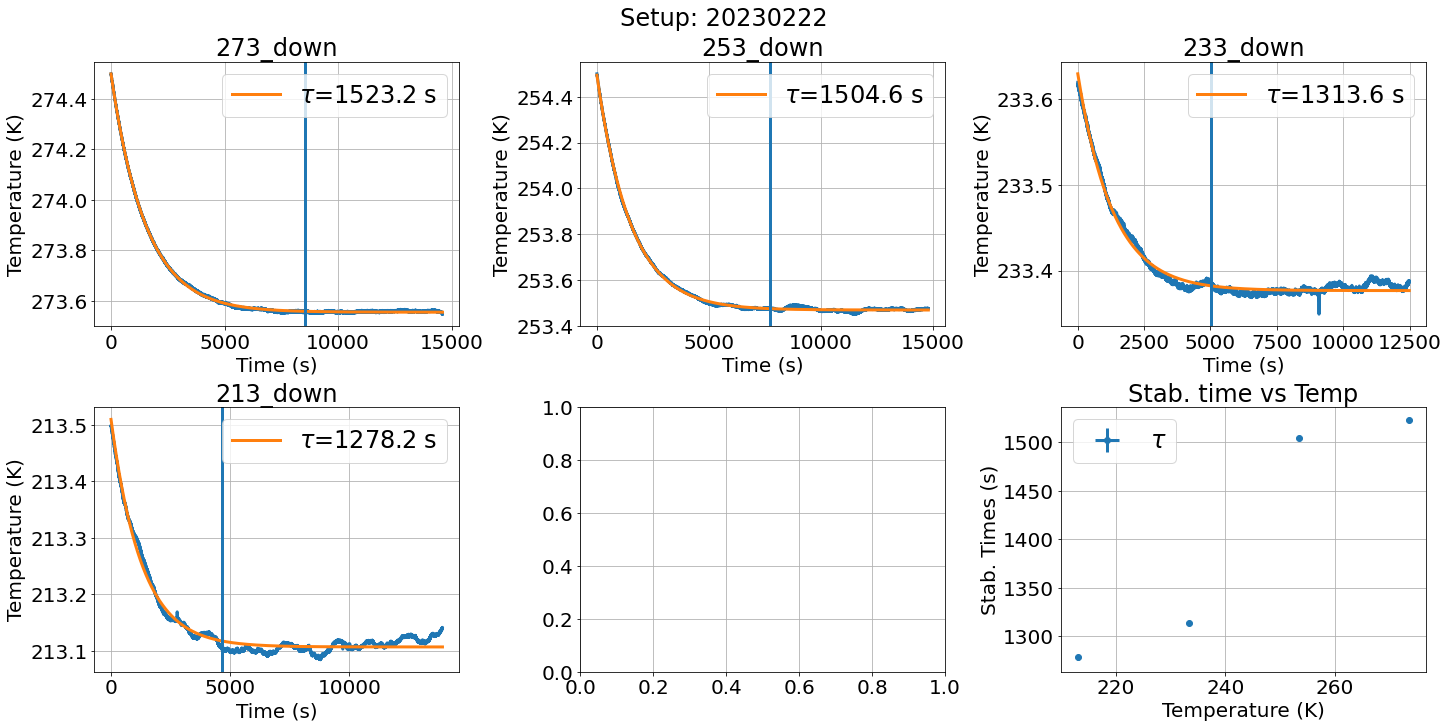

In [4]:
date = "20230222"
plot = plot_stabilization_time(date, ids, ncols=3, nrows=2)

Keys to read: ['Temp1']


Reading temperature key: Temp: 100%|██████████| 1/1 [00:00<00:00, 18.82it/s]


253_down Stabilisation time: 5305 s for tolerance 83 mK
213_down Stabilisation time: 4750 s for tolerance 77 mK


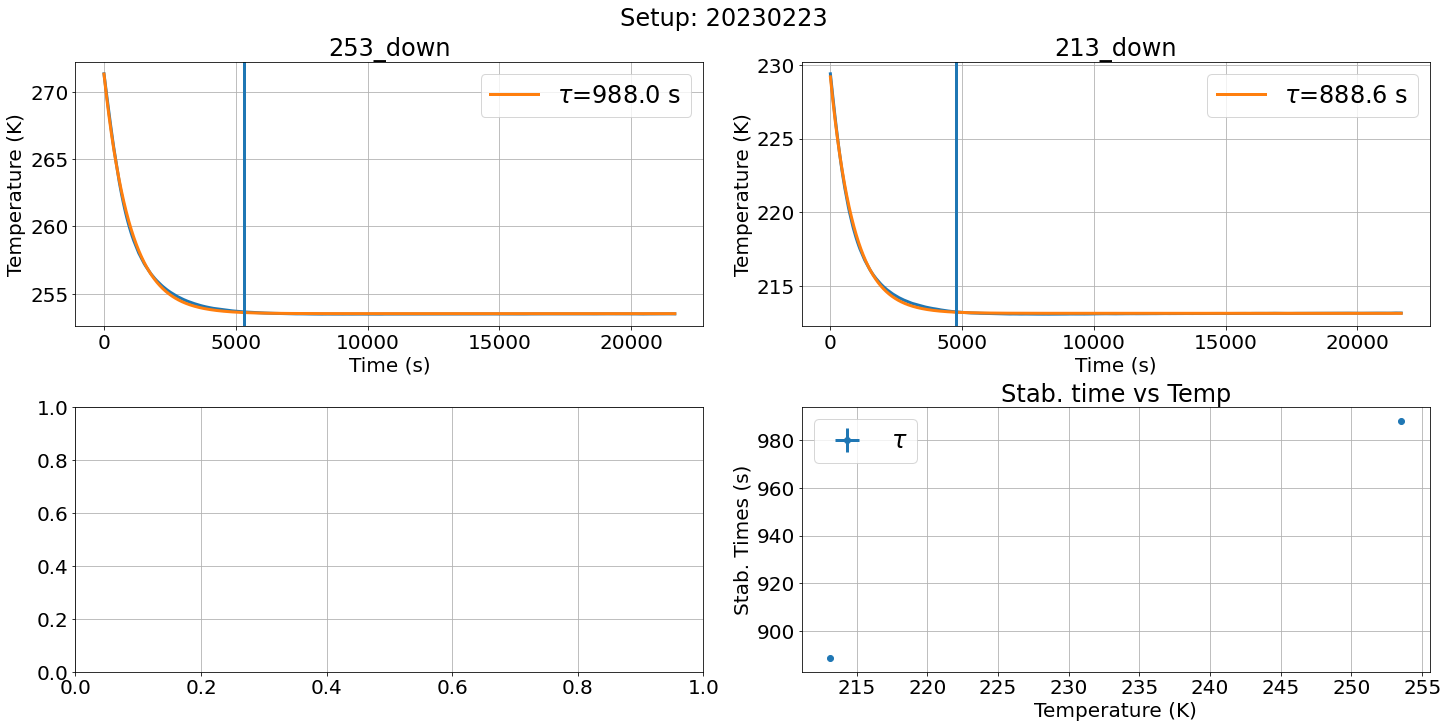

In [5]:
date = "20230223"
plot = plot_stabilization_time(date, ids, ncols=2, nrows=2)

Keys to read: ['Temp1']


Reading temperature key: Temp: 100%|██████████| 1/1 [00:00<00:00,  4.45it/s]


293_down Stabilisation time: 3526 s for tolerance 2 mK
283_down Stabilisation time: 4327 s for tolerance 119 mK
273_down Stabilisation time: 3947 s for tolerance 110 mK
263_down Stabilisation time: 5167 s for tolerance 57 mK
253_down Stabilisation time: 5021 s for tolerance 55 mK
243_down Stabilisation time: 4776 s for tolerance 59 mK
233_down Stabilisation time: 4351 s for tolerance 71 mK
223_down Stabilisation time: 4860 s for tolerance 46 mK
213_down Stabilisation time: 4488 s for tolerance 47 mK
223_up Stabilisation time: 4873 s for tolerance 72 mK
233_up Stabilisation time: 4461 s for tolerance 89 mK
243_up Stabilisation time: 4982 s for tolerance 70 mK
253_up Stabilisation time: 5029 s for tolerance 77 mK
263_up Stabilisation time: 5145 s for tolerance 76 mK
273_up Stabilisation time: 4993 s for tolerance 91 mK


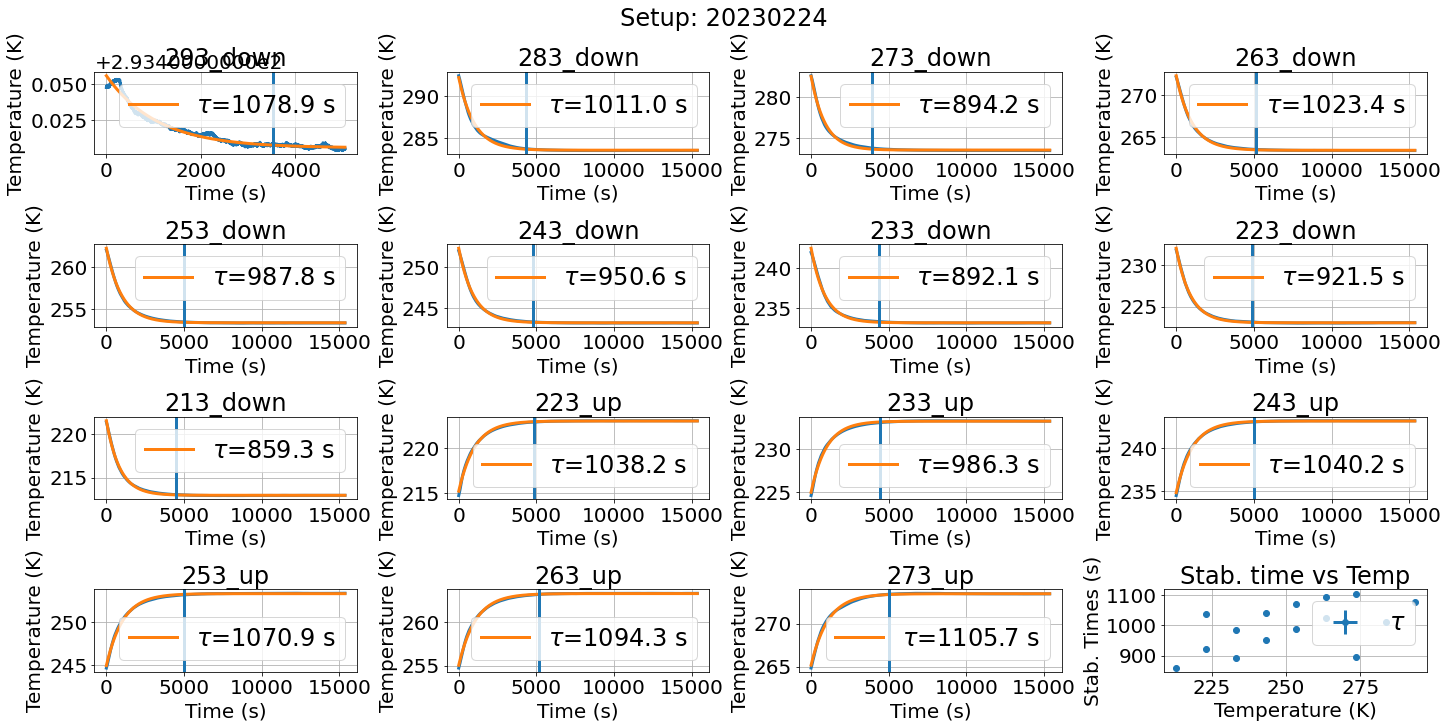

In [6]:
date = "20230224"
plot = plot_stabilization_time(date, ids, ncols=4, nrows=4)

Keys to read: ['Temp1']


Reading temperature key: Temp: 100%|██████████| 1/1 [00:00<00:00, 12.58it/s]


Keys to read: ['Temp1']


Reading temperature key: Temp: 100%|██████████| 1/1 [00:00<00:00, 14.23it/s]


Keys to read: ['Temp1']


Reading temperature key: Temp: 100%|██████████| 1/1 [00:00<00:00, 29.80it/s]


Keys to read: ['Temp1']


Reading temperature key: Temp: 100%|██████████| 1/1 [00:00<00:00, 10.77it/s]


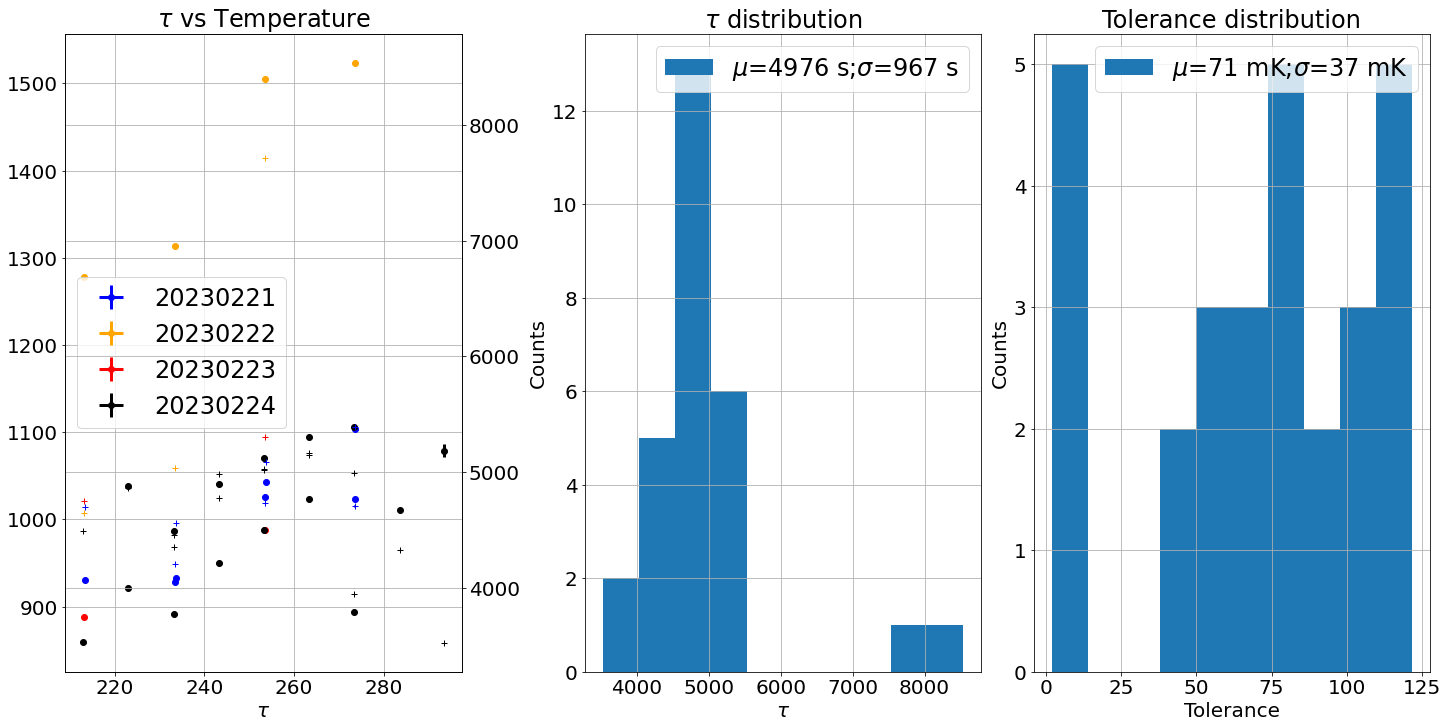

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

In [7]:
def make_stabilisation_summary(filetype="temperature", show="False"):
    fig, axes = graphic_tools.make_figure(ncols=3, nrows=1)
    twin_axes = axes[0].twinx()
    fig.set_size_inches((20,10))
    colors = {"20230221":"blue", "20230222":"orange", "20230223":"red", "20230224":"black"}
    tolerance = []
    tau = []
    tinf = []
    for date in ["20230221", "20230222", "20230223", "20230224"]:
        temps, temps_err, taus, taus_err, tolerances, tinfs = plot_stabilization_time(date,
                                                                                      ids,
                                                                                      filetype=filetype,
                                                                                      ncols=4, nrows=4, show=show)
        axes[0].errorbar(
            temps,
            taus,
            xerr=temps_err,
            yerr=taus_err,
            label=date,
            fmt="o",
            color=colors[date]
        )
        twin_axes.errorbar(
            temps,
            tinfs,
            xerr=temps_err,
            label=date,
            fmt="+",
            color=colors[date]
        )
        tolerance += tolerances
        tau += taus
        tinf += tinfs
    if filetype=="temperature":
        axes[2].hist(tolerance, label=r"$\mu$={0:.0f} mK;$\sigma$={1:.0f} mK".format(np.mean(tolerance), np.std(tolerance)))
        axes[1].hist(tinf, label=r"$\mu$={0:.0f} s;$\sigma$={1:.0f} s".format(np.mean(tinf), np.std(tinf)))
        axes[0].set_title(r"$\tau$ vs Temperature")
        axes[0].set_xlabel("Temperature (K)")
    if filetype=="peaks":
        axes[2].hist(tolerance, label=r"$\mu$={0:.3f} pm;$\sigma$={1:.3f} pm".format(np.mean(tolerance)*1e9, 1e9*np.std(tolerance)))
        axes[1].hist(tinf, label=r"$\mu$={0:.0f} s;$\sigma$={1:.0f} s".format(np.mean(tinf), np.std(tinf)))
        axes[0].set_title(r"$\tau$ vs Wavelength")
        axes[0].set_xlabel("Wavelength (m)")
    axes[0].set_xlabel(r"$\tau$")
    axes[1].set_title(r"$\tau$ distribution")
    axes[1].set_xlabel(r"$\tau$")
    axes[1].set_ylabel("Counts")
    axes[2].set_title(r"Tolerance distribution")
    axes[2].set_xlabel(r"Tolerance")
    axes[2].set_ylabel("Counts")
    axes[0].legend()
    axes[1].legend()
    axes[2].legend()
make_stabilisation_summary(filetype="temperature", show=False)

In [8]:
#This is the average time needed to stabilise for all february runs, with 3 sigma significance
tau = 4976 + 3*967

## 20230221 ##
# Description of the setup #
The 20230221 setup description can be found below:
* Only two RTDs were connected: RTD1 and RTD2.
* RTD1 was placed on the top position, close to the top of the cylinder.
* RTD2 was placed just behind the FBGs, close to the bottom part of the copper cylinder.

Keys to read: ['Temp1']


Reading temperature key: Temp: 100%|██████████| 1/1 [00:00<00:00, 15.55it/s]

Length of plateau: 48 min
Length of plateau: 50 min
Length of plateau: 50 min
Length of plateau: 110 min
Length of plateau: 50 min
Length of plateau: 50 min
Length of plateau: 50 min


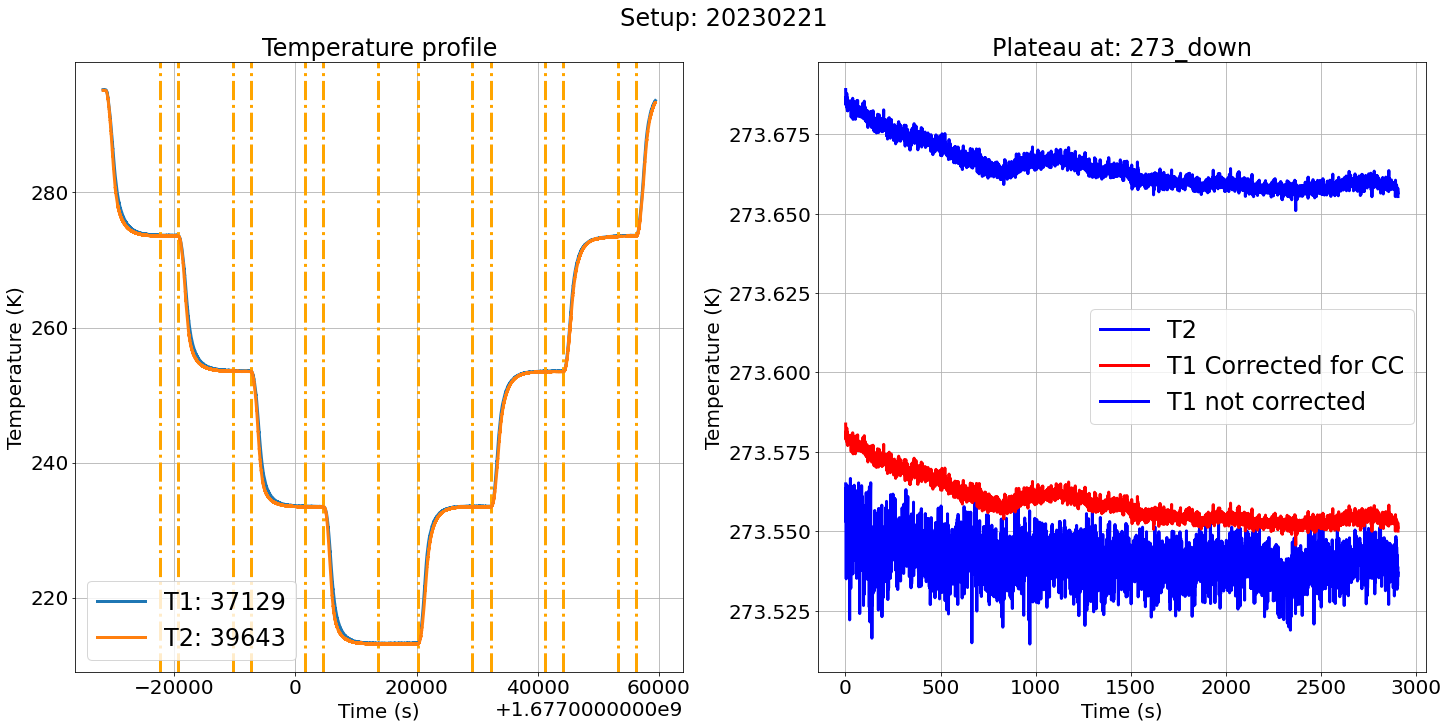

In [9]:
date = "20230221"
ids = {"T1":"37129", "T2":"39643"}
colors = {"T1":"blue", "T2":"orange", "T3":"red", "T4":"green", "T5":"purple", "T6":"black"}
ref = "T2"
def plot_temperature_profile(date, ids, t0):
    rtds = getters.get_raw_data(path_to_split=path+date+"/",
                                filetype="temperature",
                                pol="Temp").sort_values(by="Timestamp").reset_index(drop=True)
    fig, axes = graphic_tools.make_figure(ncols=2, nrows=1)
    fig.set_size_inches(20, 10)
    fig.suptitle("Setup: " + date)
    for sens in ids.keys():
        axes[0].plot(rtds["Timestamp"], rtds[sens], label=sens + ": " + ids[sens])
        if sens == ref:
            continue
        for plateau in plateaus[date].keys():
            t0 = plateaus[date][plateau][0] + tau
            tf = plateaus[date][plateau][1]
            print("Length of plateau: {0:.0f} min".format((tf-t0)/60))
            axes[0].axvline(t0, linestyle="-.", color="orange")
            axes[0].axvline(tf, linestyle="-.", color="orange")
            if plateau != "273_down":
                continue
            tcut = rtds.loc[(rtds["Timestamp"]>t0)&(rtds["Timestamp"]<tf)]
            cc = line(int(plateau.split("_")[0]), rtdcalib[ids[ref]][ids[sens]][0], rtdcalib[ids[ref]][ids[sens]][1])
            axes[1].plot(tcut["Timestamp"]-t0, tcut[ref], color="blue", label=ref)
            axes[1].plot(tcut["Timestamp"]-t0, tcut[sens] - cc, color="red", label=sens + " Corrected for CC")
            axes[1].plot(tcut["Timestamp"]-t0, tcut[sens], color="blue", label=sens + " not corrected")
            axes[1].set_title("Plateau at: " + plateau)
    axes[0].legend()
    axes[0].set_xlabel("Time (s)")
    axes[0].set_ylabel("Temperature (K)")
    axes[0].set_title("Temperature profile")
    axes[1].set_xlabel("Time (s)")
    axes[1].set_ylabel("Temperature (K)")
    axes[1].legend()
plot_temperature_profile(date, ids, 8000)

Keys to read: ['Temp1']


Reading temperature key: Temp: 100%|██████████| 1/1 [00:00<00:00, 11.90it/s]
No handles with labels found to put in legend.


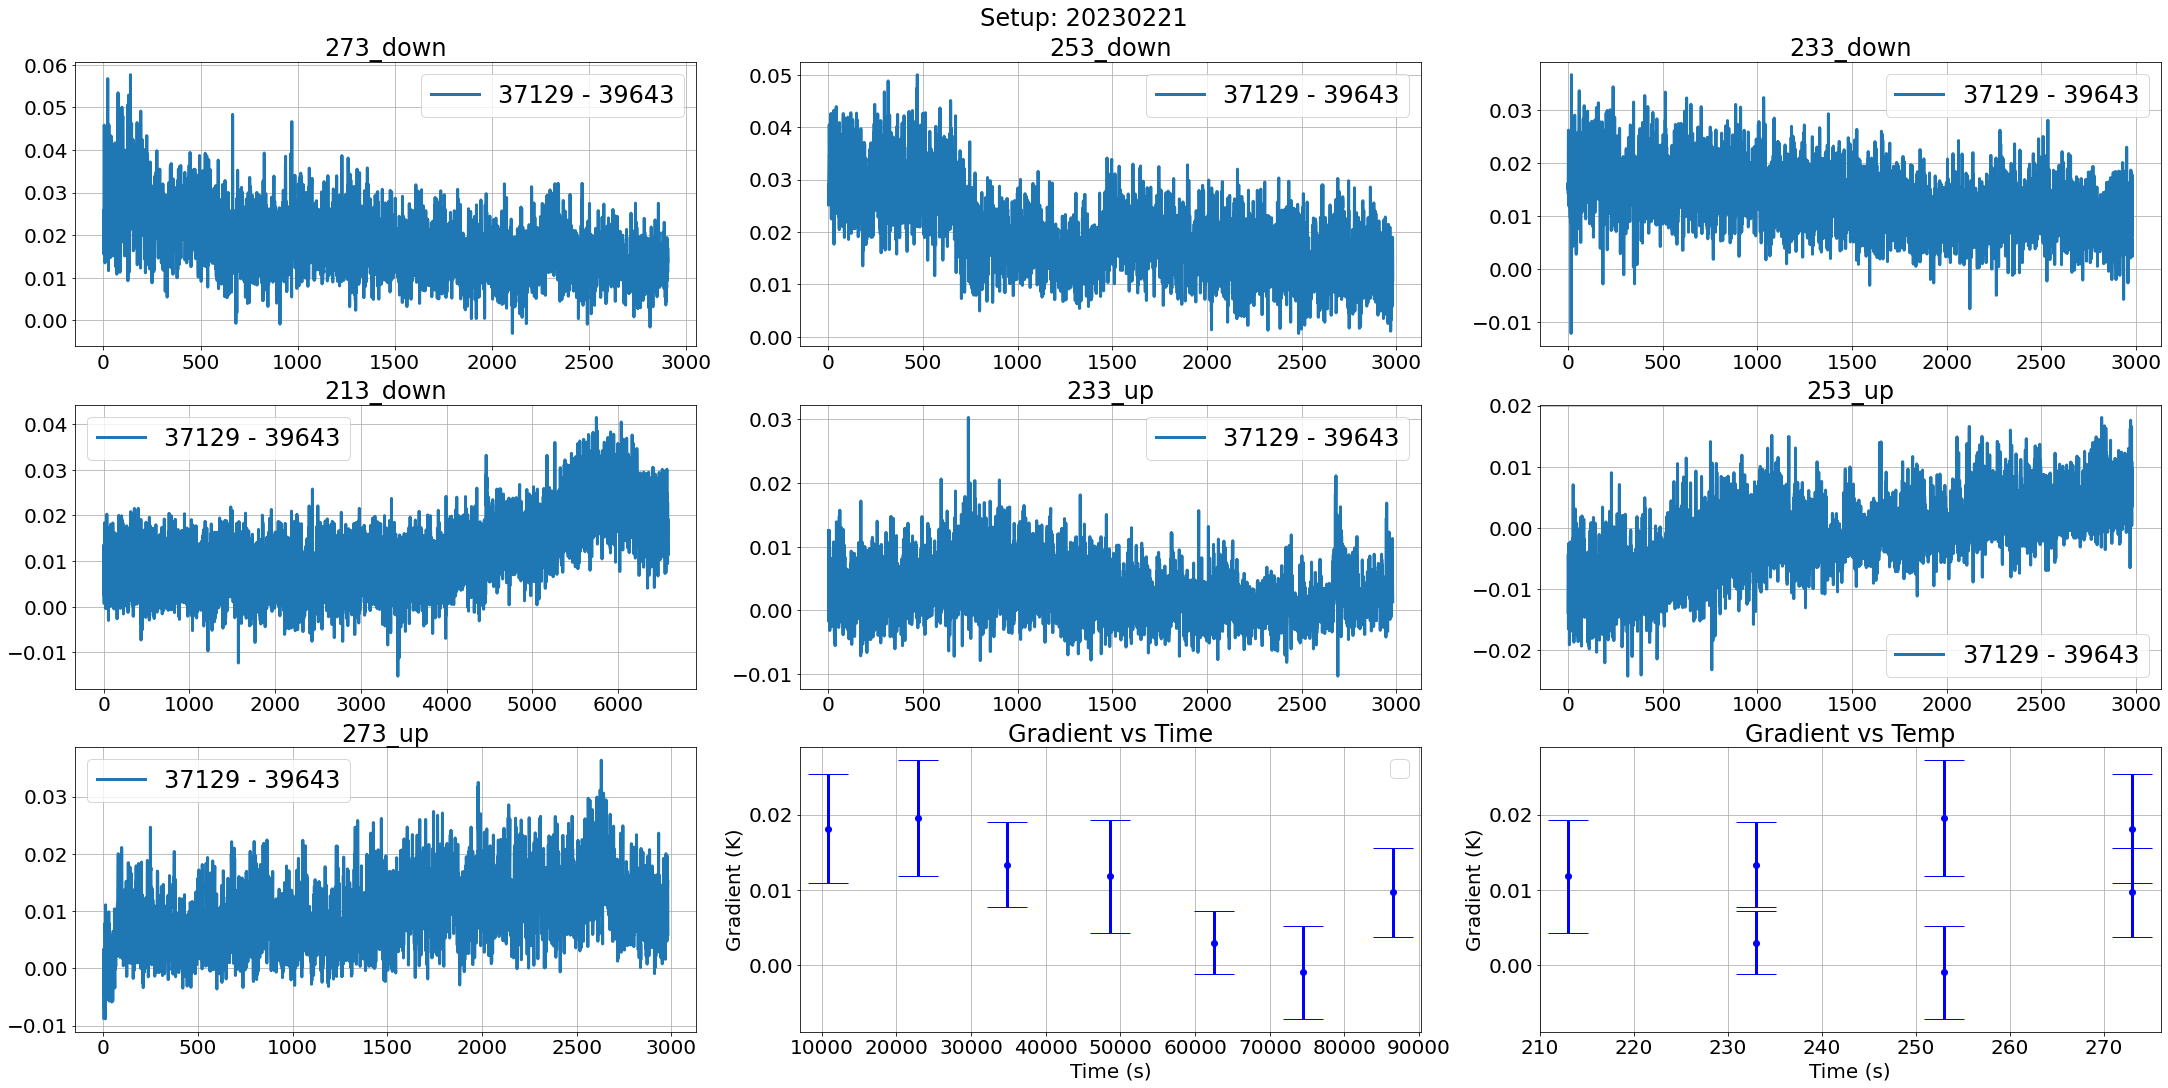

In [10]:
date = "20230221"
ids = {"T1":"37129", "T2":"39643"}
def plot_temperature_plateau(date, ids):
    rtds = getters.get_raw_data(path_to_split=path+date+"/",
                                filetype="temperature",
                                pol="Temp").sort_values(by="Timestamp").reset_index(drop=True)
    fig, axes = graphic_tools.make_figure(ncols=3, nrows=3)
    fig.set_size_inches(30, 15)
    fig.suptitle("Setup: " + date)
    cnt = 0
    ref = "T2"
    for plateau in plateaus[date]:
        for sens in ids.keys():
            if sens == ref:
                continue
            if plateau != "273_down":
                t0 = plateaus[date][plateau][0] + tau
                tf = plateaus[date][plateau][1]
            else:
                t0 = plateaus[date][plateau][0] + tau
                tf = plateaus[date][plateau][1]
            tcut = rtds.loc[(rtds["Timestamp"]>t0)&(rtds["Timestamp"]<tf)]
            cc = line(int(plateau.split("_")[0]), rtdcalib[ids[ref]][ids[sens]][0], rtdcalib[ids[ref]][ids[sens]][1])
            axes[cnt].plot(tcut["Timestamp"]-t0, tcut[sens]-tcut[ref] - cc, label=ids[sens] + " - " + ids[ref])
            axes[8].errorbar(int(plateau.split("_")[0]), np.mean(tcut[sens]-tcut[ref] - cc),
                             linestyle="-.", fmt="o",
                             yerr=np.std(tcut[sens]-tcut[ref] - cc), color="blue", capsize=20)
            axes[7].errorbar(np.mean(tcut["Timestamp"]-rtds["Timestamp"][0]),
                             np.mean(tcut[sens]-tcut[ref] - cc),
                             linestyle="-.", fmt="o",
                             yerr=np.std(tcut[sens]-tcut[ref] - cc), color="blue", capsize=20)
        axes[cnt].set_title(plateau)
        axes[cnt].legend()
        axes[7].set_title("Gradient vs Time")
        axes[7].set_xlabel("Time (s)")
        axes[7].set_ylabel("Gradient (K)")
        axes[8].set_xlabel("Time (s)")
        axes[8].set_title("Gradient vs Temp")
        axes[8].set_ylabel("Gradient (K)")
        cnt += 1
    axes[7].legend()
plot_temperature_plateau(date, ids)

Keys to read: ['Temp1']


Reading temperature key: Temp: 100%|██████████| 1/1 [00:00<00:00, 11.68it/s]


Keys to read: ['Hum1']


Reading humidity key: Hum: 100%|██████████| 1/1 [00:00<00:00, 17.96it/s]


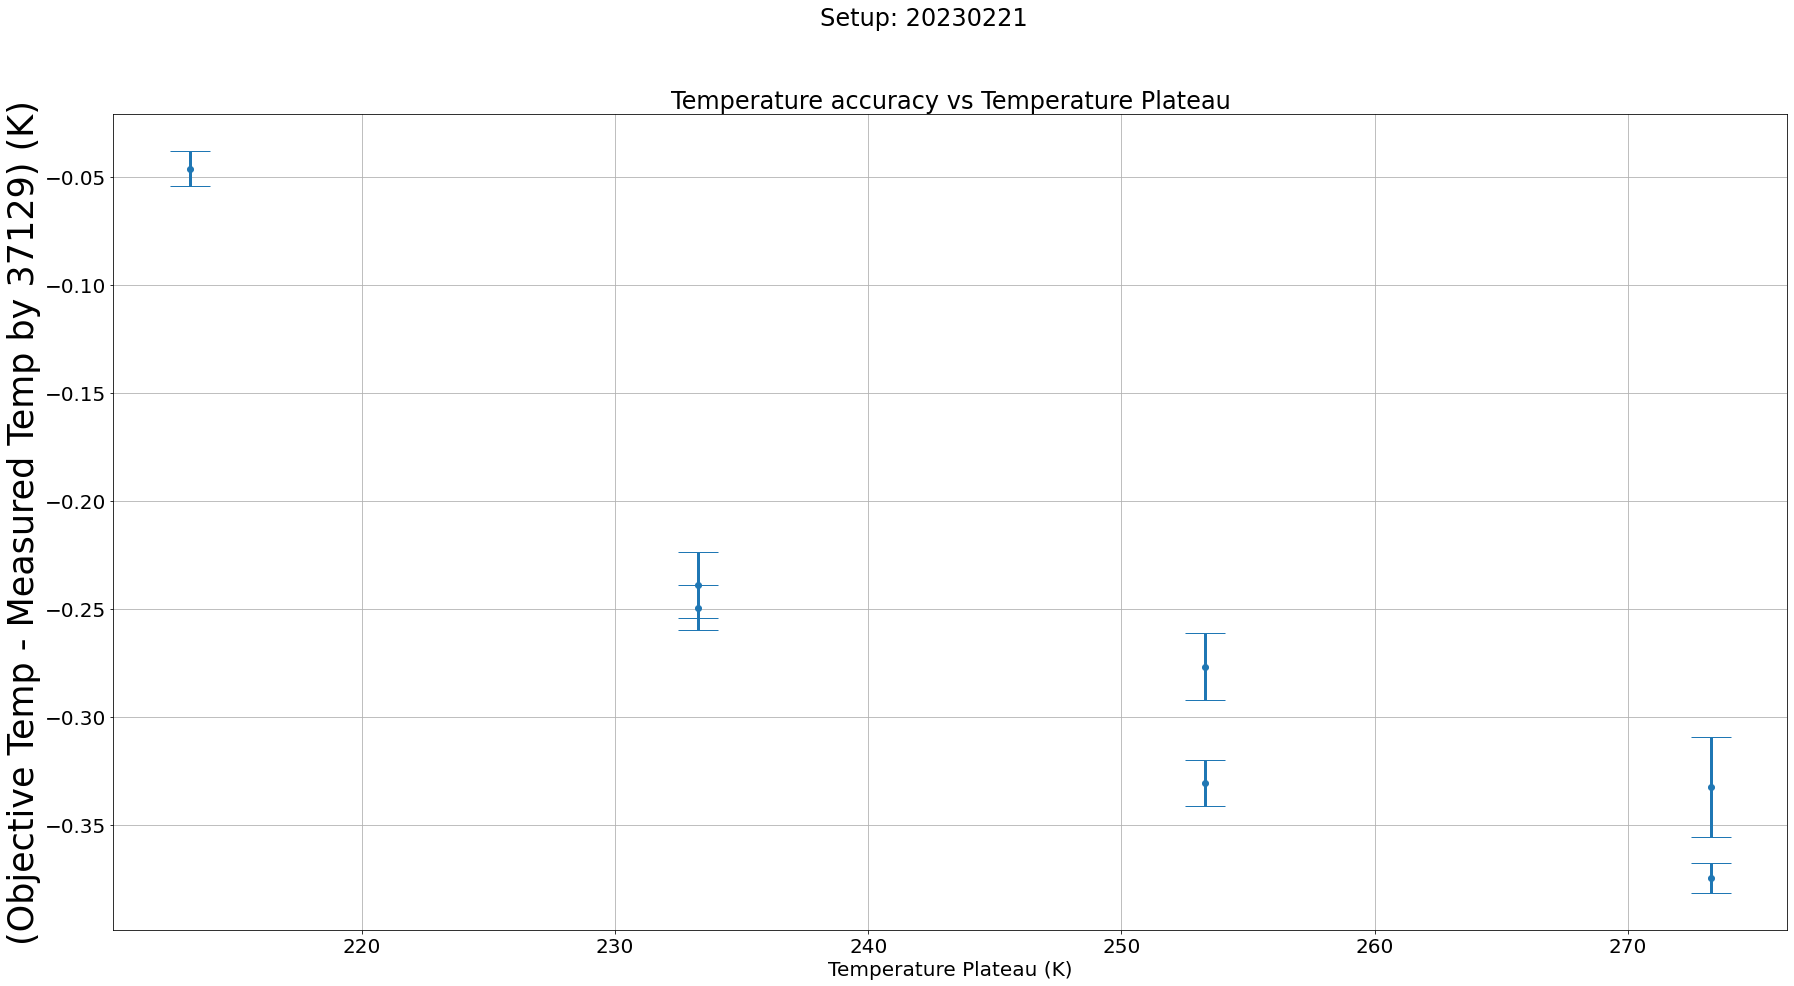

In [11]:
date = "20230221"
ids = {"T1":"37129", "T2":"39643"}
def plot_temperature_accuracy(date, ids, show=False):
    rtds = getters.get_raw_data(path_to_split=path+date+"/",
                                filetype="temperature",
                                pol="Temp").sort_values(by="Timestamp").reset_index(drop=True)
    climatic_chamber = getters.get_raw_data(path_to_split=path+date+"/",
                                filetype="humidity",
                                pol="Hum").sort_values(by="Timestamp").reset_index(drop=True)
    fig, axes = plt.subplots(nrows=1, ncols=1)
    fig.set_size_inches(30, 15)
    fig.suptitle("Setup: " + date)
    cnt = 0
    sens = "T1"
    ref = "T2"
    temps, temps_err = [], []
    accuracies, accuracies_err = [], []
    for plateau in plateaus[date]:
        t0 = plateaus[date][plateau][0] + tau
        tf = plateaus[date][plateau][1]
        tcut = rtds.loc[(rtds["Timestamp"]>t0)&(rtds["Timestamp"]<tf)]
        ccut = climatic_chamber.loc[(climatic_chamber["Timestamp"]>t0)&(climatic_chamber["Timestamp"]<tf)]
        cc = line(int(plateau.split("_")[0]), rtdcalib[ids[ref]][ids[sens]][0], rtdcalib[ids[ref]][ids[sens]][1])
        objT = np.mean(ccut["T"]) + 273.14
        obsT = tcut[sens]
        temps.append(objT)
        temps_err.append(np.std(ccut["T"]))
        accuracies.append(np.mean(objT-obsT))
        accuracies_err.append(np.std(objT-obsT))
    axes.errorbar(
        temps,
        accuracies,
        yerr=accuracies_err,
        fmt="o",
        capsize=20
    )
    axes.set_title("Temperature accuracy vs Temperature Plateau")
    axes.set_xlabel("Temperature Plateau (K)")
    axes.set_ylabel(r"(Objective Temp - Measured Temp by {0}) (K)".format(ids[sens]), fontsize=35)
    if show==False:
        fig.clf()
    return temps, accuracies, accuracies_err
plot = plot_temperature_accuracy(date, ids, show=True)

## 20230222 ##
# Description of the setup #
The 20230222 setup description can be found below:
* Only two RTDs were connected: RTD1 and RTD2.
* RTD1 was placed on the top position, close to the top of the cylinder.
* RTD2 was placed just behind the FBGs, close to the bottom part of the copper cylinder.

Keys to read: ['Temp1']


Reading temperature key: Temp: 100%|██████████| 1/1 [00:00<00:00, 17.58it/s]
No handles with labels found to put in legend.


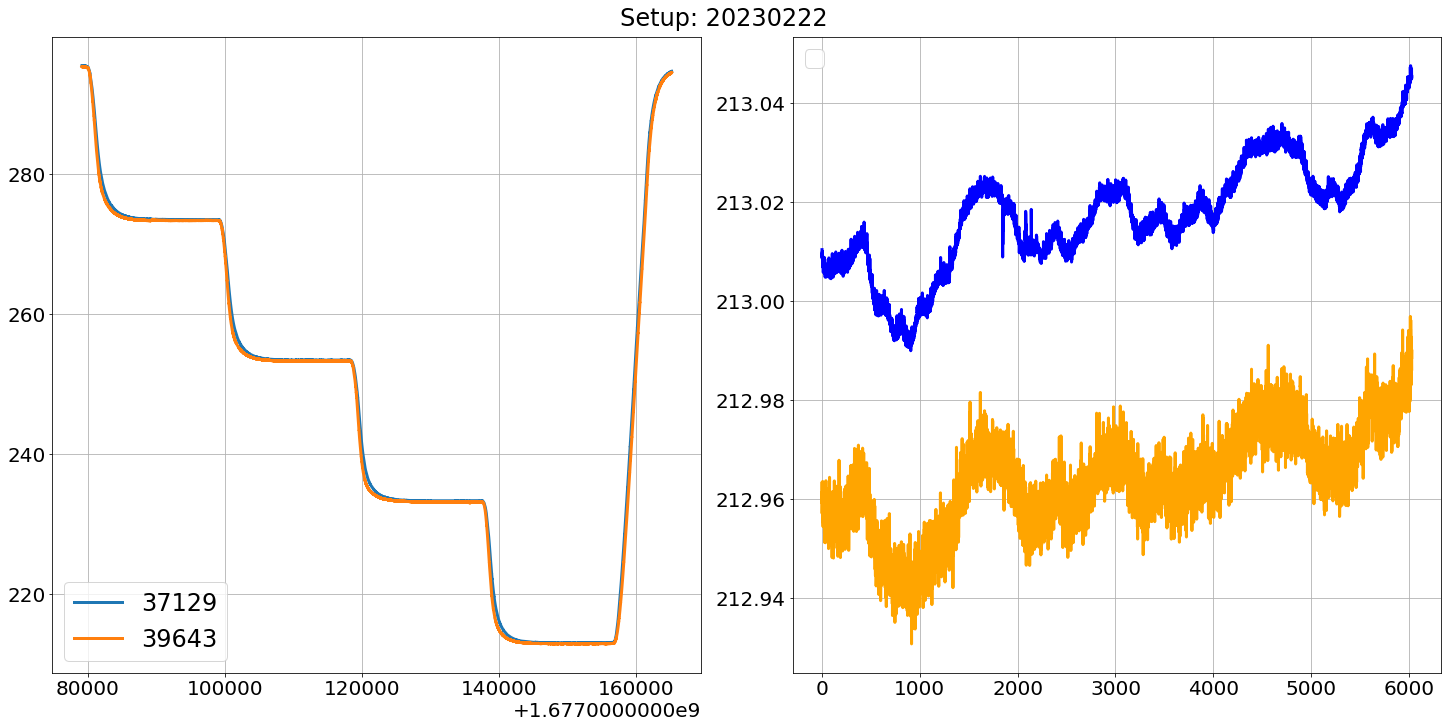

In [12]:
date = "20230222"
ids = {"T1":"37129", "T2":"39643"}
colors = {"T1":"blue", "T2":"orange", "T3":"red", "T4":"green", "T5":"purple", "T6":"black"}
ref = "T2"
def plot_temperature_profile(date, ids):
    rtds = getters.get_raw_data(path_to_split=path+date+"/",
                                filetype="temperature",
                                pol="Temp").sort_values(by="Timestamp").reset_index(drop=True)
    fig, axes = graphic_tools.make_figure(ncols=2, nrows=1)
    fig.set_size_inches(20, 10)
    fig.suptitle("Setup: " + date)
    for sens in ids.keys():
        axes[0].plot(rtds["Timestamp"], rtds[sens], label=ids[sens])
        for plateau in plateaus[date].keys():
            if plateau != "213_down":
                continue
            t0 = plateaus[date][plateau][0] + tau
            tf = plateaus[date][plateau][1]
            tcut = rtds.loc[(rtds["Timestamp"]>t0)&(rtds["Timestamp"]<tf)]
            cc = line(int(plateau.split("_")[0]), rtdcalib[ids[ref]][ids[sens]][0], rtdcalib[ids[ref]][ids[sens]][1])
            axes[1].plot(tcut["Timestamp"]-t0, tcut[sens] - cc, color=colors[sens])
    axes[0].legend()
    axes[1].legend()
plot_temperature_profile(date, ids)

Keys to read: ['Temp1']


Reading temperature key: Temp: 100%|██████████| 1/1 [00:00<00:00, 13.61it/s]
No handles with labels found to put in legend.


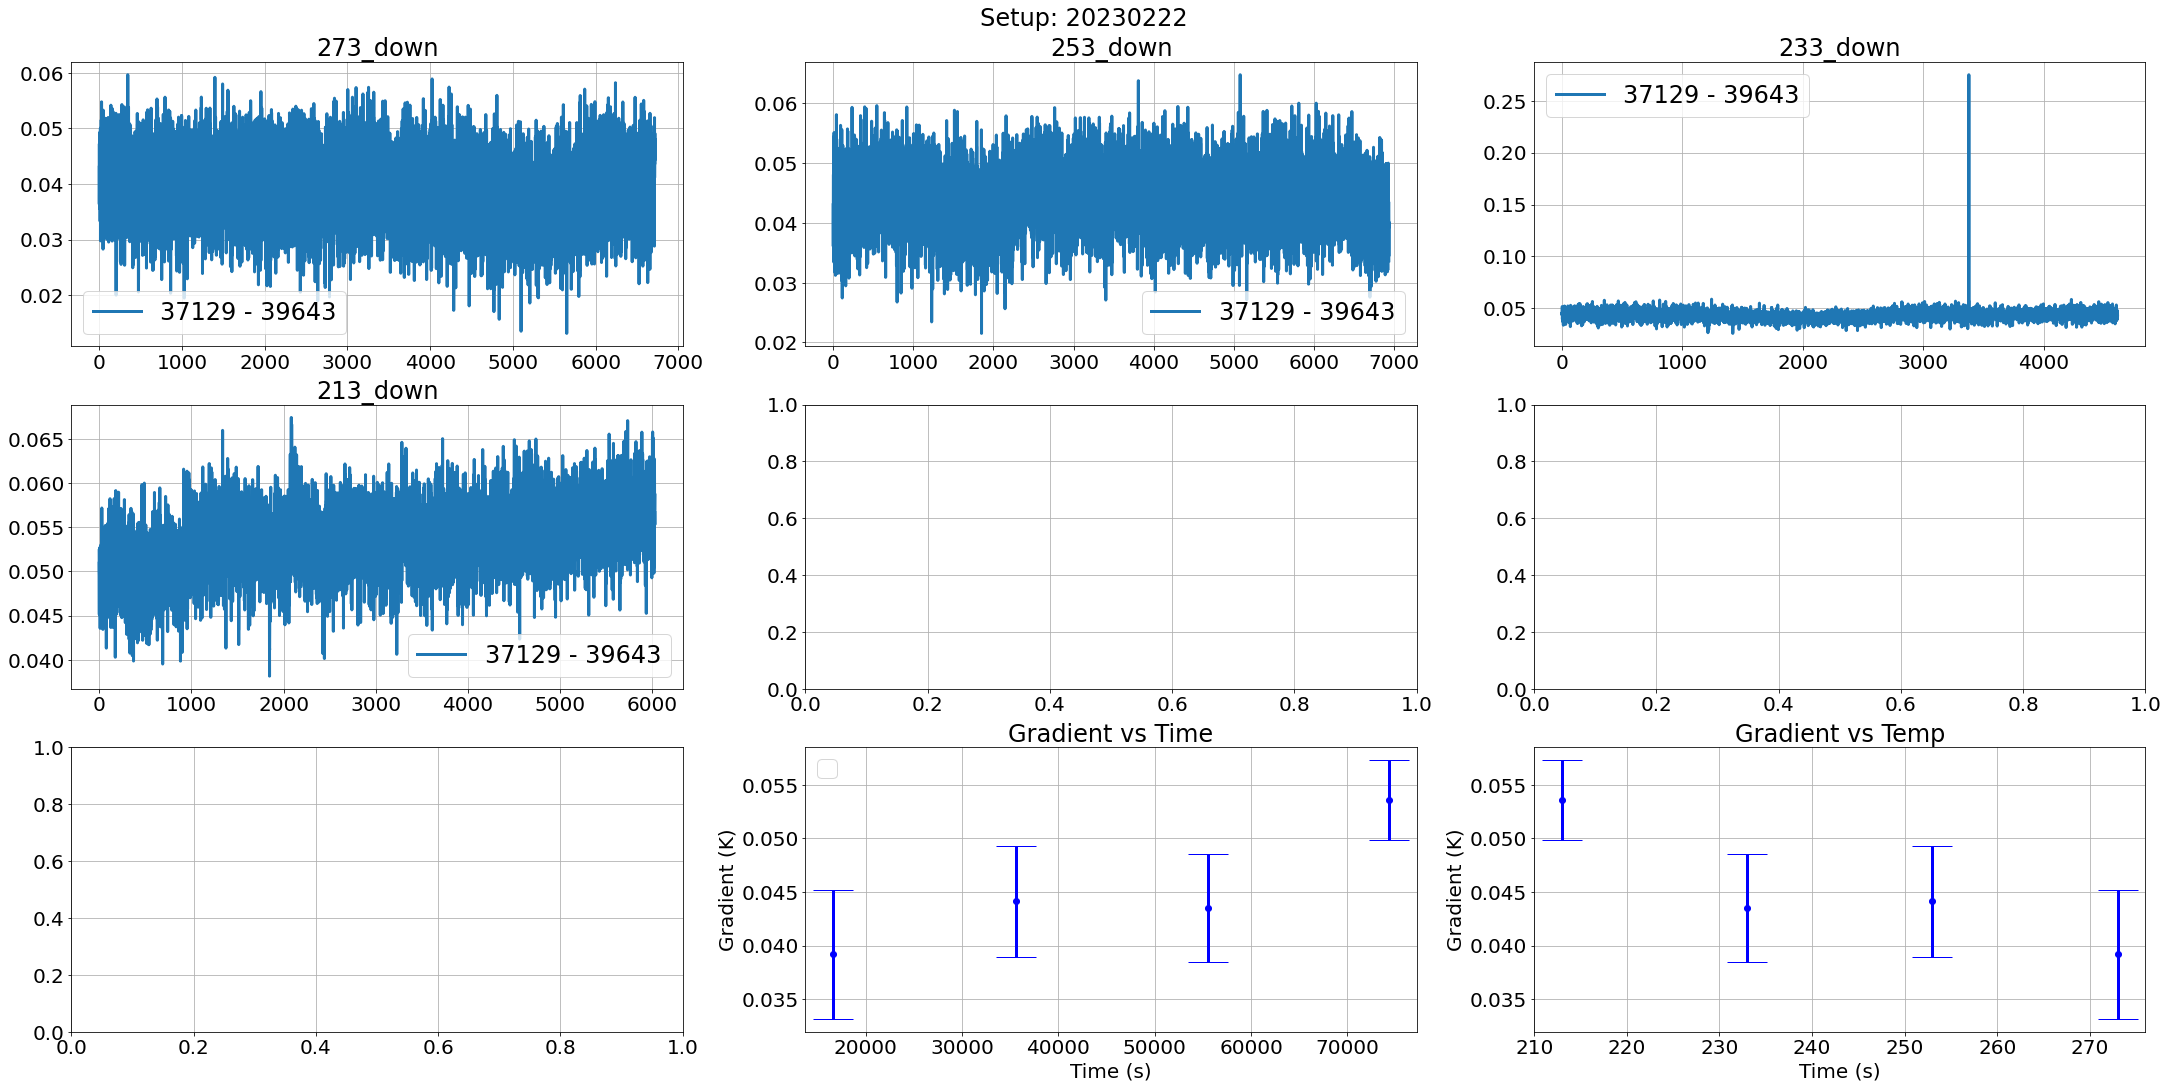

In [13]:
date = "20230222"
ids = {"T1":"37129", "T2":"39643"}
plot_temperature_plateau(date, ids)

Keys to read: ['Temp1']


Reading temperature key: Temp: 100%|██████████| 1/1 [00:00<00:00,  9.79it/s]


Keys to read: ['Hum1']


Reading humidity key: Hum: 100%|██████████| 1/1 [00:00<00:00,  9.11it/s]


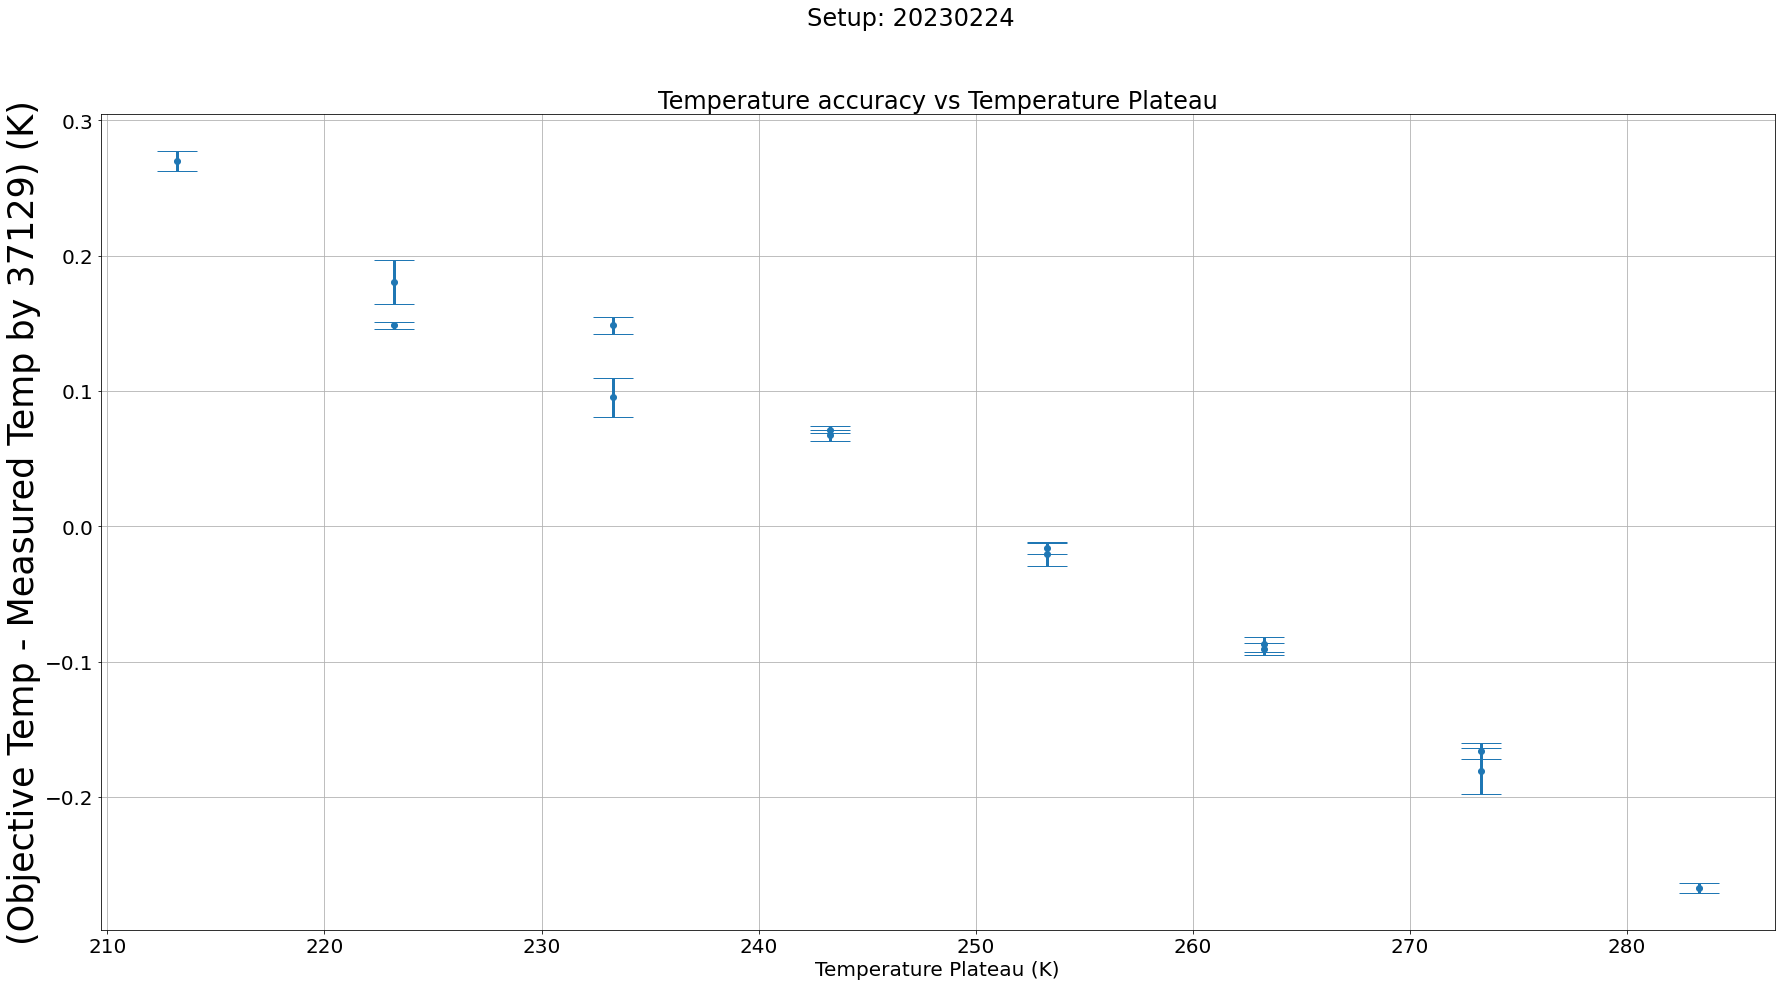

In [14]:
date = "20230224"
ids = {"T1":"37129", "T2":"39643"}
plot = plot_temperature_accuracy(date, ids, show=True)

Keys to read: ['Temp1']


Reading temperature key: Temp: 100%|██████████| 1/1 [00:00<00:00, 15.98it/s]


Keys to read: ['Temp1']


Reading temperature key: Temp: 100%|██████████| 1/1 [00:00<00:00, 16.58it/s]


Keys to read: ['Temp1']


Reading temperature key: Temp: 100%|██████████| 1/1 [00:00<00:00, 36.67it/s]


Keys to read: ['Temp1']


Reading temperature key: Temp: 100%|██████████| 1/1 [00:00<00:00, 13.61it/s]


Keys to read: ['Temp1']


Reading temperature key: Temp: 100%|██████████| 1/1 [00:00<00:00, 24.56it/s]


Keys to read: ['Temp1']


Reading temperature key: Temp: 100%|██████████| 1/1 [00:00<00:00, 27.61it/s]


Text(0.5, 0, 'Temperature Plateau (K)')

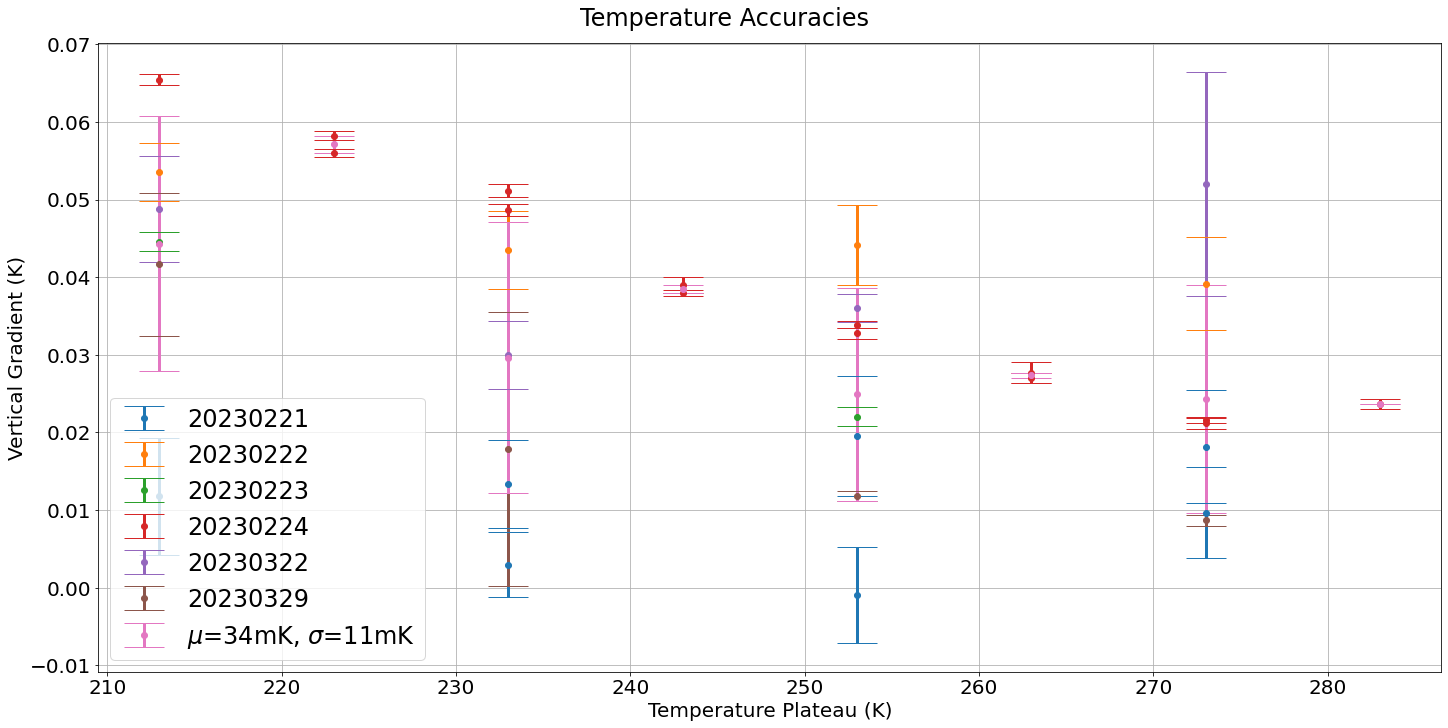

In [38]:
fig, axes = graphic_tools.make_figure(ncols=1, nrows=1)
fig.set_size_inches(20, 10)
fig.suptitle("Temperature Accuracies")
accuracy = {}
temps = {}
acc_res = {}
acc_err = {}
temp_res = {}
for plateau in plateaus["20230224"].keys():
    if plateau.split("_")[0] == "293":
        continue
    accuracy[plateau.split("_")[0]] = []
    temps[plateau.split("_")[0]] = []
sens = "T1"
ref="T2"
for date in ["20230221", "20230222", "20230223", "20230224", "20230322", "20230329"]:
    if "03" in date:
        path = "/eos/user/j/jcapotor/FBGana/camara_climatica/MarchRuns/"
    else:
        path = "/eos/user/j/jcapotor/FBGana/camara_climatica/FebruaryRuns/"
    rtds = getters.get_raw_data(path_to_split=path+date+"/",
                                filetype="temperature",
                                pol="Temp").sort_values(by="Timestamp").reset_index(drop=True)
    temperature, temps_err = [], []
    accuracies, accuracies_err = [], []
    for plateau in plateaus[date]:
        t0 = plateaus[date][plateau][0] + tau
        tf = plateaus[date][plateau][1]
        cc = line(int(plateau.split("_")[0]), rtdcalib[ids[ref]][ids[sens]][0], rtdcalib[ids[ref]][ids[sens]][1])
        tcut = rtds.loc[(rtds["Timestamp"]>t0)&(rtds["Timestamp"]<tf)]
        objT = int(plateau.split("_")[0])
        obsT = tcut[sens]-tcut[ref]-cc
        # obsT = objT-tcut[sens]
        temperature.append(objT)
        temps_err.append(np.std(ccut["T"]))
        accuracies.append(np.mean(obsT))
        accuracies_err.append(np.std(objT-obsT))
        if plateau.split("_")[0] == "293":
            continue
        accuracy[plateau.split("_")[0]].append(np.mean(obsT))
        temps[plateau.split("_")[0]].append(objT)
    axes.errorbar(
        temperature,
        accuracies,
        yerr=accuracies_err,
        fmt="o",
        capsize=20,
        label=date
    )

for plateau in accuracy.keys():
    acc_res[plateau] = np.mean(accuracy[plateau])
    acc_err[plateau] = np.std(accuracy[plateau])
    temp_res[plateau] = np.mean(temps[plateau])

mean = np.mean(list(acc_res.values()))
sigma = np.std(list(acc_res.values()))
axes.errorbar(
    temp_res.values(),
    acc_res.values(),
    yerr=acc_err.values(),
    fmt="o",
    label=r"$\mu$={0:.0f}mK, $\sigma$={1:.0f}mK".format(mean*1e3,sigma*1e3),
    capsize=20
)
axes.legend()
# axes.set_ylabel(r"(Obj. T - Measured T by {0}) (K)".format(sens))
axes.set_ylabel(r"Vertical Gradient (K)")
axes.set_xlabel("Temperature Plateau (K)")
        
    

## 20230223 ##
# Description of the setup #
The 20230223 setup description can be found below:
* A total of 6 RTDs were connected.
* RTD1 was placed on the top position, close to the top of the cylinder.
* RTD2 was placed just behind the FBGs, close to the bottom part of the copper cylinder.

Keys to read: ['Temp1']


Reading temperature key: Temp: 100%|██████████| 1/1 [00:00<00:00, 34.12it/s]


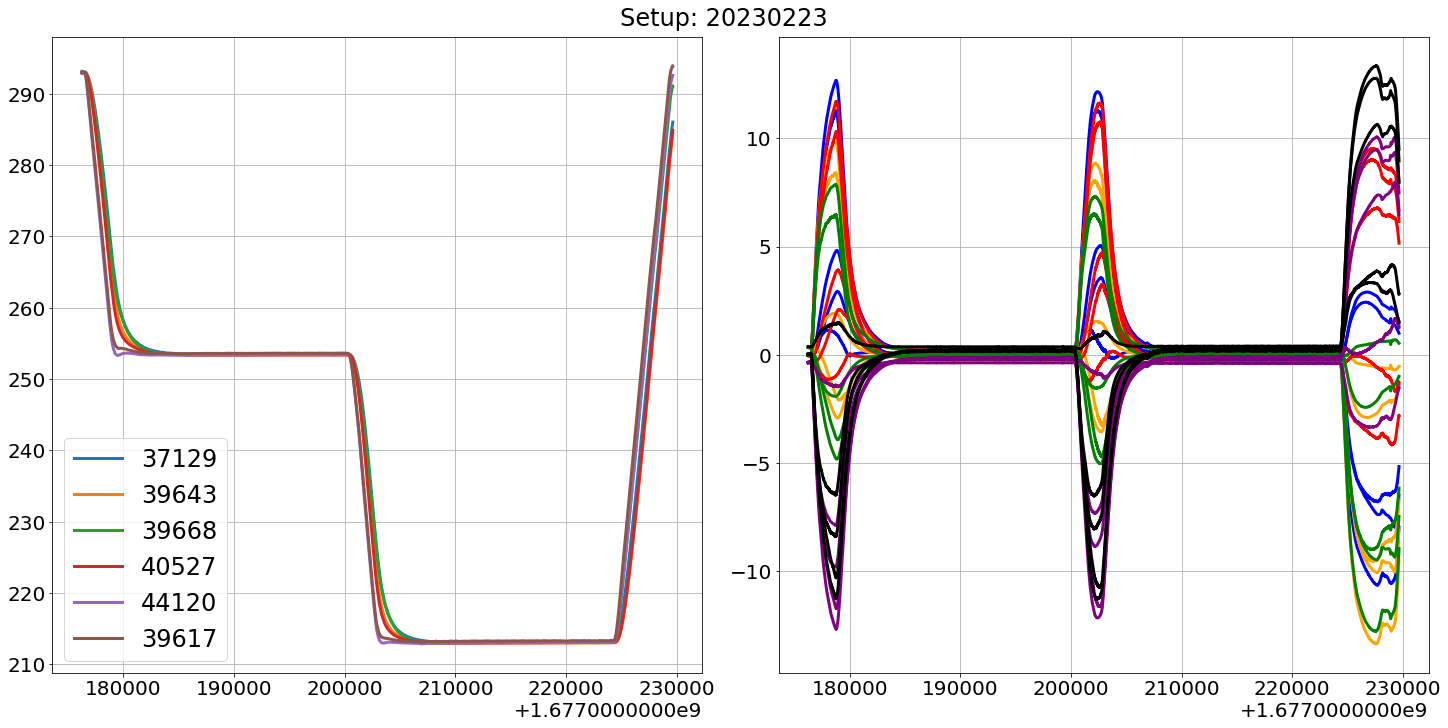

In [16]:
date = "20230223"
ids = {"T1":"37129", "T2":"39643", "T3":"39668", "T4":"40527", "T5":"44120", "T6":"39617"}
colors = {"T1":"blue", "T2":"orange", "T3":"red", "T4":"green", "T5":"purple", "T6":"black"}
def plot_temperature_profile(date, ids):
    rtds = getters.get_raw_data(path_to_split=path+date+"/",
                                filetype="temperature",
                                pol="Temp").sort_values(by="Timestamp").reset_index(drop=True)
    fig, axes = graphic_tools.make_figure(ncols=2, nrows=1)
    fig.set_size_inches(20, 10)
    fig.suptitle("Setup: " + date)
    for sens in ids.keys():
        axes[0].plot(rtds["Timestamp"], rtds[sens], label=ids[sens])
        for ref in ids.keys():
            if ref == sens:
                continue
            cc = line(rtds[ref], rtdcalib[ids[ref]][ids[sens]][0], rtdcalib[ids[ref]][ids[sens]][1])
            axes[1].plot(rtds["Timestamp"], rtds[sens]-rtds[ref] - cc, label=ids[sens] + " - " + ids[ref], color=colors[sens])
    axes[0].legend()
plot_temperature_profile(date, ids)

Keys to read: ['Temp1']


Reading temperature key: Temp: 100%|██████████| 1/1 [00:00<00:00, 35.80it/s]
No handles with labels found to put in legend.


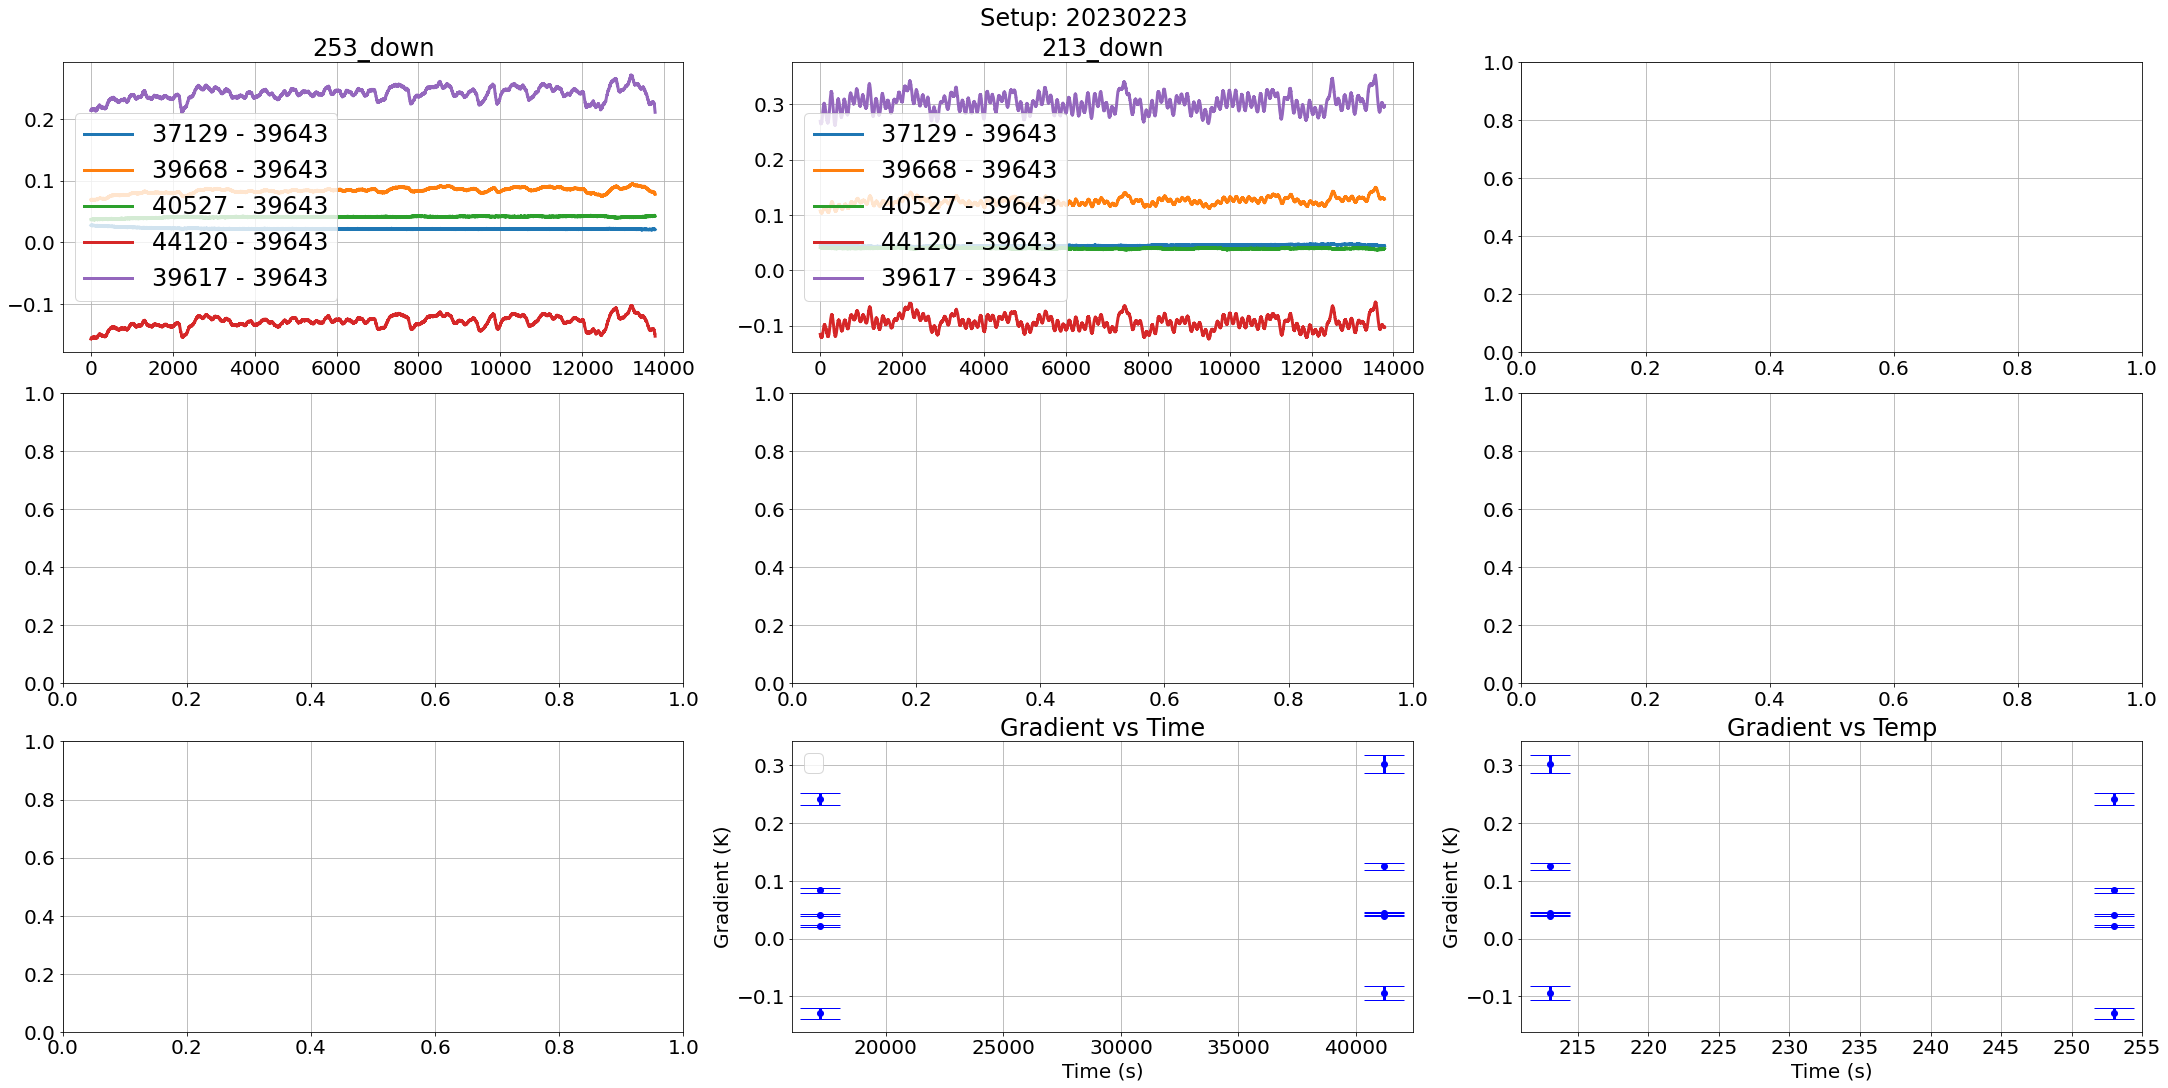

In [17]:
date = "20230223"
ids = {"T1":"37129", "T2":"39643", "T3":"39668", "T4":"40527", "T5":"44120", "T6":"39617"}
colors = {"T1":"blue", "T2":"orange", "T3":"red", "T4":"green", "T5":"purple", "T6":"black"}
plot_temperature_plateau(date, ids)

## 20230224 ##
# Description of the setup #
The 20230224 setup description can be found below:
* A total of 6 RTDs were connected.
* RTD1 was placed on the top position, close to the top of the cylinder.
* RTD2 was placed just behind the FBGs, close to the bottom part of the copper cylinder.

Keys to read: ['Temp1']


Reading temperature key: Temp: 100%|██████████| 1/1 [00:00<00:00, 10.51it/s]


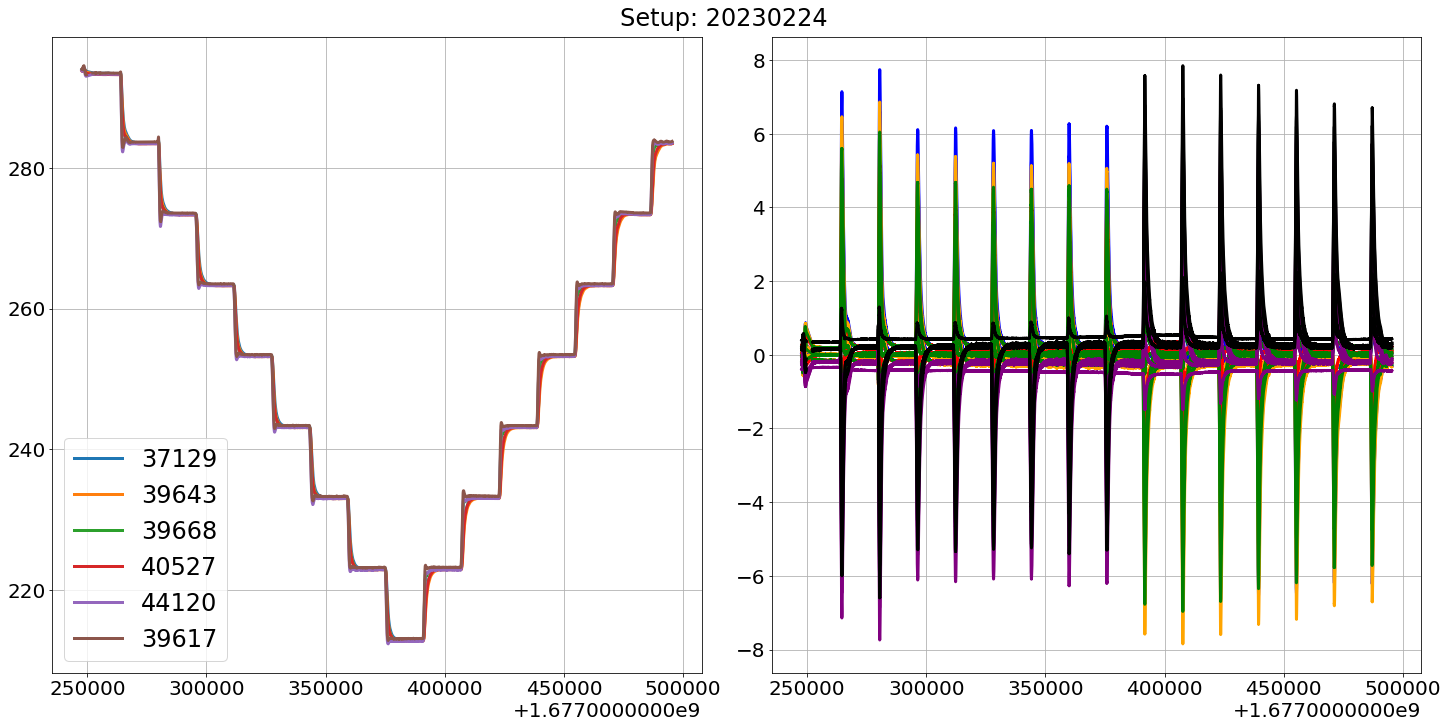

In [18]:
date = "20230224"
ids = {"T1":"37129", "T2":"39643", "T3":"39668", "T4":"40527", "T5":"44120", "T6":"39617"}
colors = {"T1":"blue", "T2":"orange", "T3":"red", "T4":"green", "T5":"purple", "T6":"black"}
def plot_temperature_profile(date, ids):
    rtds = getters.get_raw_data(path_to_split=path+date+"/",
                                filetype="temperature",
                                pol="Temp").sort_values(by="Timestamp").reset_index(drop=True)
    fig, axes = graphic_tools.make_figure(ncols=2, nrows=1)
    fig.set_size_inches(20, 10)
    fig.suptitle("Setup: " + date)
    for sens in ids.keys():
        axes[0].plot(rtds["Timestamp"], rtds[sens], label=ids[sens])
        for ref in ids.keys():
            if ref == sens:
                continue
            cc = line(rtds[ref], rtdcalib[ids[ref]][ids[sens]][0], rtdcalib[ids[ref]][ids[sens]][1])
            axes[1].plot(rtds["Timestamp"], rtds[sens]-rtds[ref] - cc, label=ids[sens] + " - " + ids[ref], color=colors[sens])
    axes[0].legend()
plot_temperature_profile(date, ids)

Keys to read: ['Temp1']


Reading temperature key: Temp: 100%|██████████| 1/1 [00:00<00:00, 10.61it/s]

Index(['Date', 'Time', 'T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'Timestamp'], dtype='object')



No handles with labels found to put in legend.


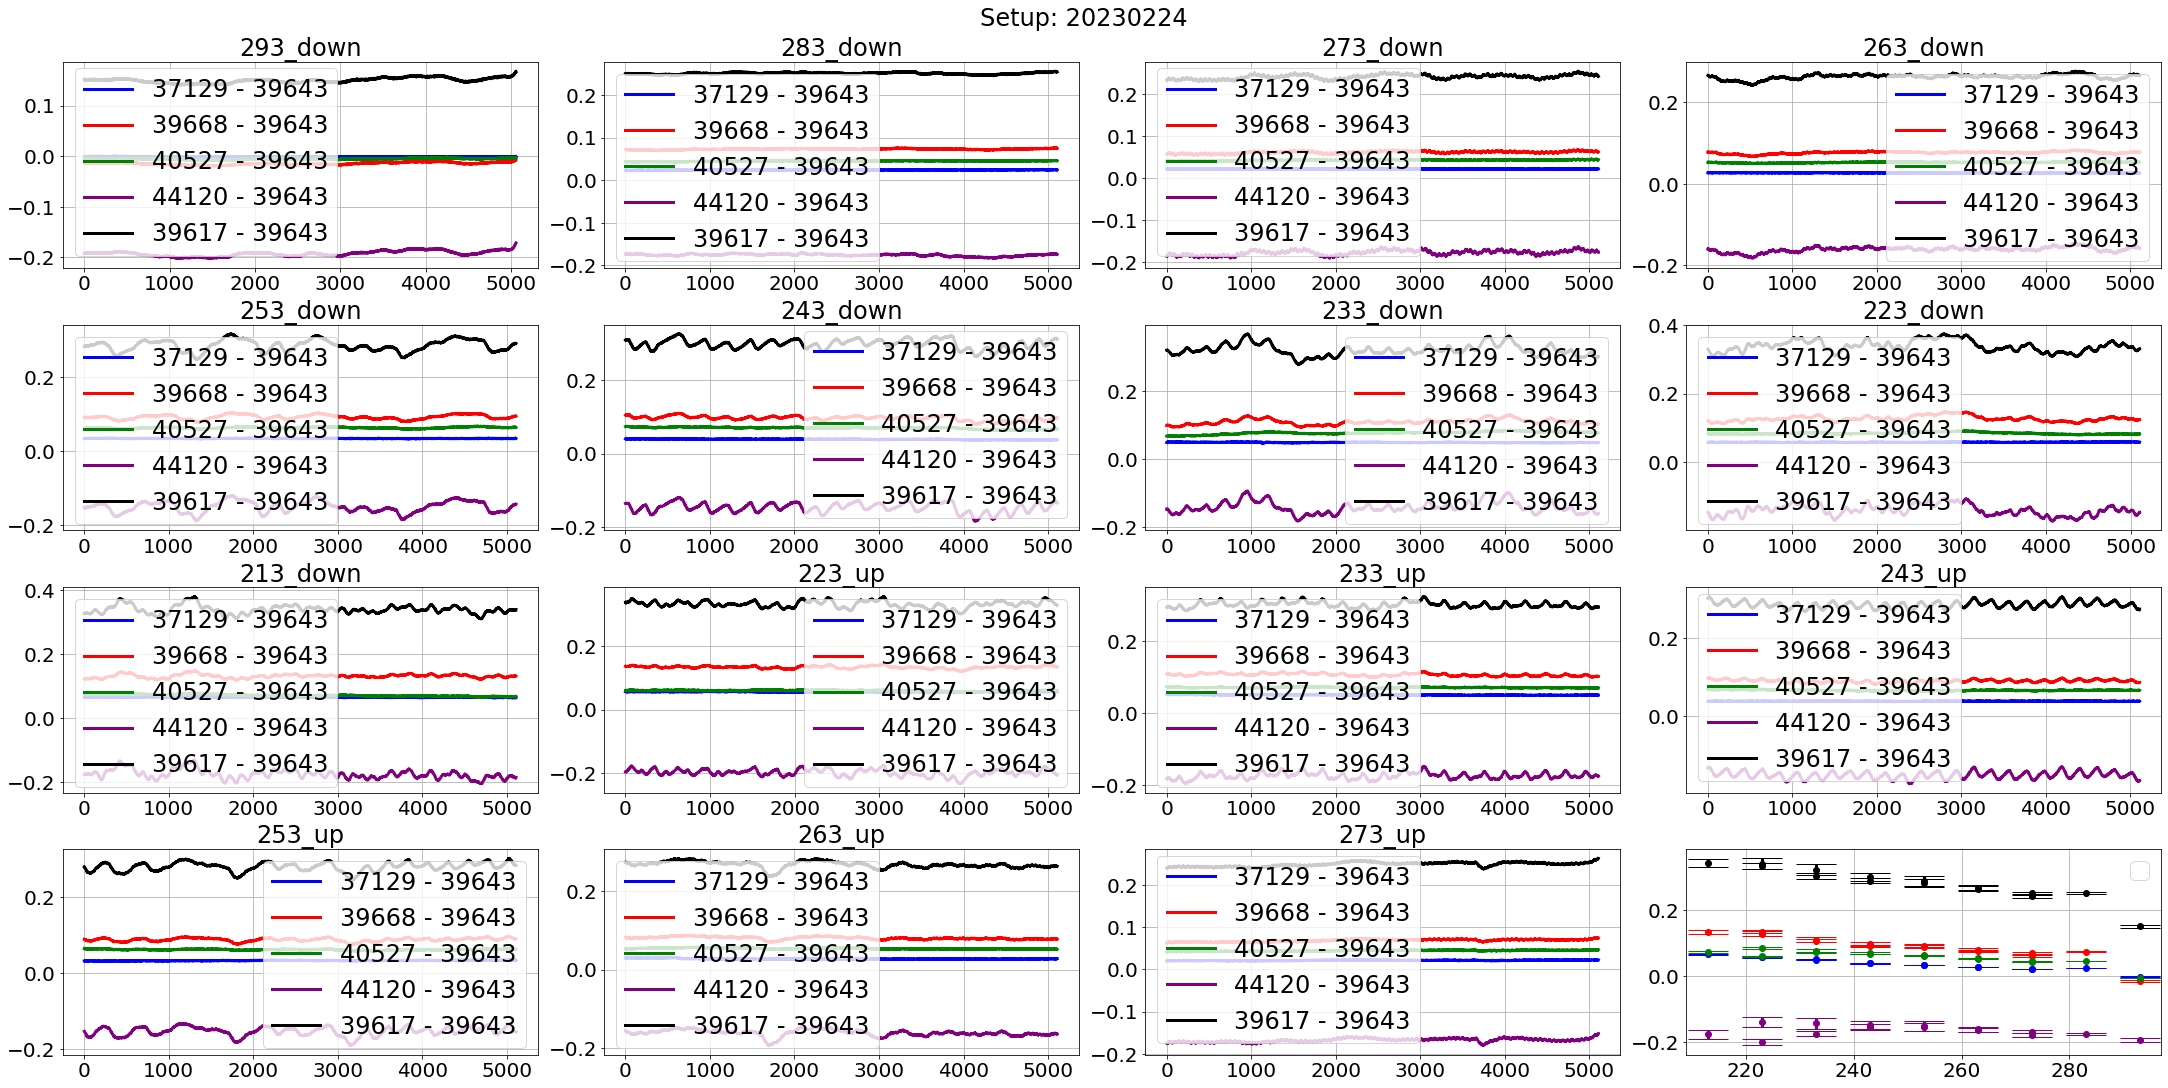

In [19]:
date = "20230224"
ids = {"T1":"37129", "T2":"39643", "T3":"39668", "T4":"40527", "T5":"44120", "T6":"39617"}
colors = {"T1":"blue", "T2":"orange", "T3":"red", "T4":"green", "T5":"purple", "T6":"black"}
def plot_temperature_plateau(date, ids):
    rtds = getters.get_raw_data(path_to_split=path+date+"/",
                                filetype="temperature",
                                pol="Temp").sort_values(by="Timestamp").reset_index(drop=True)
    print(rtds.columns)
    fig, axes = graphic_tools.make_figure(ncols=4, nrows=4)
    fig.set_size_inches(30, 15)
    fig.suptitle("Setup: " + date)
    cnt = 0
    ref = "T2"
    for plateau in plateaus[date]:
        for sens in ids.keys():
            if sens == ref:
                continue
            if plateau != "293_down":
                t0 = plateaus[date][plateau][0] + 10000
                tf = plateaus[date][plateau][1] - 250
            else:
                t0 = plateaus[date][plateau][0]
                tf = plateaus[date][plateau][1]
            tcut = rtds.loc[(rtds["Timestamp"]>t0)&(rtds["Timestamp"]<tf)]
            cc = line(int(plateau.split("_")[0]), rtdcalib[ids[ref]][ids[sens]][0], rtdcalib[ids[ref]][ids[sens]][1])
            axes[cnt].plot(tcut["Timestamp"]-t0, tcut[sens]-tcut[ref] - cc,
                           color=colors[sens],
                           label=ids[sens] + " - " + ids[ref])
            axes[15].errorbar(int(plateau.split("_")[0]), np.mean(tcut[sens]-tcut[ref] - cc),
                             color=colors[sens],
                             linestyle="-.", fmt="o",
                             yerr=np.std(tcut[sens]-tcut[ref] - cc), capsize=20)
        axes[cnt].set_title(plateau)
        axes[cnt].legend()
        cnt += 1
    axes[15].legend()
plot_temperature_plateau(date, ids)